In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import igraph
import warnings
warnings.filterwarnings('ignore')

In [2]:
ddir = "/home/scai/PhenPred/data/"
data_folder = "/home/scai/PhenPred/data/clines"

In [3]:
ss_cmp = pd.read_csv(f"{data_folder}/model_list_20230505.csv", index_col=0)

# Growth
growth = pd.read_csv(f"{data_folder}/growth_rate_20220907.csv")
growth = (
    growth.sort_values(["model_id", "replicates"], ascending=False)
    .groupby("model_id")
    .first()
)
growth = growth.dropna(subset=["day4_day1_ratio"])

In [4]:
cnv_measured = pd.read_csv(f"{data_folder}/cnv_summary_20230303_matrix.csv", index_col=0)

In [5]:
## CRISPR-Cas9
cas9_measured = pd.read_csv(
    f"{data_folder}/depmap23Q2/CRISPRGeneEffect.csv", index_col=0
)
cas9_measured.columns = cas9_measured.columns.str.split(" ").str[0]
# cas9_measured = scale(cas9_measured.T).T
cas9_measured = cas9_measured.rename(
    index=ss_cmp.reset_index().groupby("BROAD_ID").first()["model_id"]
)

In [6]:
measured_cnv_only = list(set(cnv_measured.index) - set(cas9_measured.index))
measured_cas9_only = list(set(cas9_measured.index) - set(cnv_measured.index))
measured_both = list(set(cnv_measured.index) & set(cas9_measured.index))

In [7]:
measured_groups = {
    "both": measured_both,
    "cnv_only": measured_cnv_only,
    "cas9_only": measured_cas9_only,
    "none": [],  # Will be automatically assigned for remaining samples
}

In [8]:
timestamp = "20241211_171745"
# Datasets - synthetic
## Transcriptomics
cnv_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_copynumber.csv.gz",
    index_col=0,
)

## CRISPR-Cas9
cas9_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_crisprcas9.csv.gz",
    index_col=0,
)

In [9]:
skew_df = pd.concat(
    [
        cas9_measured.apply(skew).astype(float).rename("skew_orig"),
        cas9_df.apply(skew).astype(float).rename("skew_mosa"),
    ],
    axis=1,
)


def build_string_ppi(score_thres=900):
    # ENSP map to gene symbol
    gmap = pd.read_csv(f"../data/ppi/9606.protein.aliases.v12.0.txt.gz", sep="\t")
    gmap = gmap[["BioMart_HUGO" in i.split(" ") for i in gmap["source"]]]
    gmap = gmap.groupby("#string_protein_id")["alias"].agg(lambda x: set(x)).to_dict()
    gmap = {k: list(gmap[k])[0] for k in gmap if len(gmap[k]) == 1}

    # Load String network
    net = pd.read_csv(f"../data/ppi/9606.protein.links.full.v12.0.txt.gz", sep=" ")

    # Filter by moderate confidence
    net = net[net["combined_score"] > score_thres]

    # Filter and map to gene symbol
    net = net[
        [p1 in gmap and p2 in gmap for p1, p2 in net[["protein1", "protein2"]].values]
    ]
    net["protein1"] = [gmap[p1] for p1 in net["protein1"]]
    net["protein2"] = [gmap[p2] for p2 in net["protein2"]]

    #  String network
    net_i = igraph.Graph(directed=False)

    # Initialise network lists
    edges = [(px, py) for px, py in net[["protein1", "protein2"]].values]
    vertices = list(set(net["protein1"]).union(net["protein2"]))

    # Add nodes
    net_i.add_vertices(vertices)

    # Add edges
    net_i.add_edges(edges)

    # Add edge attribute score
    net_i.es["score"] = list(net["combined_score"])

    # Simplify
    net_i = net_i.simplify(combine_edges="max")

    return net_i


ppi = build_string_ppi()


def ppi_dist_to_string(d, target_thres):
    if d == 0:
        res = "T"

    elif d == np.inf:
        res = "No link; No connection"

    elif d < target_thres:
        res = f"{int(d)}"

    else:
        res = f"{int(target_thres)}+"

    return res


def dist_crispr_gexp(crisprs, gexps, ppi):
    ppi_genes = set(ppi.vs["name"])
    genes = gexps.intersection(ppi_genes)
    assert len(genes) != 0, "No gexps overlapping with PPI provided"

    dmatrix = {
        c: dict(zip(*(genes, ppi.shortest_paths(source=c, target=genes)[0])))
        for c in crisprs
        if c in ppi_genes
    }

    return dmatrix


def ppi_annotation(df, ppi, target_thres=5):
    df_genes = set(df["x_id"])
    df_crispr = set(df["y_id"])

    # Calculate distance between gexp and crispr in PPI
    dist_d_g = dist_crispr_gexp(df_crispr, df_genes, ppi)

    # Annotate drug regressions
    def drug_gene_annot(c, g):
        if c == g:
            res = "T"

        elif c not in dist_d_g:
            res = "No link; CRISPR not in network"

        elif g not in dist_d_g[c]:
            res = "No link; Gene not in network"

        else:
            res = ppi_dist_to_string(dist_d_g[c][g], target_thres)

        return res

    df = df.assign(
        target_detailed=[drug_gene_annot(c, g) for c, g in df[["y_id", "x_id"]].values]
    )

    df = df.assign(
        target=["-" if t.startswith("No link;") else t for t in df["target_detailed"]]
    )

    return df

# pan-cancer level

In [10]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_copynumber_crisprcas9.csv.gz"
)
df_res_vae["log10p_orig"] = -np.log10(df_res_vae["pval_orig"])
df_res_vae["log10p_vae"] = -np.log10(df_res_vae["pval_vae"])
df_res_vae['diff_log10p'] = df_res_vae['log10p_vae'] - df_res_vae['log10p_orig']
df_res_vae = df_res_vae.sort_values("diff_log10p", ascending=False)

In [11]:
df_res_vae_annot = pd.merge(df_res_vae, skew_df, left_on="y_id", right_index=True)
df_res_vae_annot = ppi_annotation(df_res_vae_annot, ppi)

In [13]:
df_res_vae_annot["log10fdr_orig"] = -np.log10(df_res_vae_annot["fdr_orig"])
df_res_vae_annot["log10fdr_vae"] = -np.log10(df_res_vae_annot["fdr_vae"])
df_res_vae_annot["diff_log10fdr"] = (
    df_res_vae_annot["log10fdr_vae"] - df_res_vae_annot["log10fdr_orig"]
)

In [16]:
df_res_vae_filtered = df_res_vae_annot[df_res_vae_annot["beta_vae"].abs() > 0.06]
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 2")
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_orig < 2")
df_res_vae_filtered = df_res_vae_filtered[
    df_res_vae_filtered["target"].isin(["T", "1", "2", "3", "4", "5"])
]
df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -2 and skew_mosa < -1.5")
COLS = [
    "y_id",
    "x_id",
    "beta_orig",
    "beta_vae",
    "fdr_orig",
    "fdr_vae",
    "diff_log10fdr",
    "skew_orig",
    "skew_mosa",
    "target",
]

In [17]:
df_res_vae_filtered

,y_id,x_id,n_orig,beta_orig,lr_orig,covs_orig,pval_orig,fdr_orig,n_vae,beta_vae,...,log10p_orig,log10p_vae,diff_log10p,skew_orig,skew_mosa,target_detailed,target,log10fdr_orig,log10fdr_vae,diff_log10fdr
7500,SOX10,FHIT,706.0,-0.067761,16.796870,16.0,0.000042,0.052652,1523.0,-0.110602,...,4.380887,29.139998,24.759111,-3.568809,-3.268146,4,4,1.278588,25.389566,24.110979
6265,BRAF,FHIT,706.0,-0.065018,17.812600,16.0,0.000024,0.041932,1523.0,-0.094797,...,4.613031,26.511486,21.898455,-3.054024,-2.870718,4,4,1.377452,23.062085,21.684633
17658,SOX10,EP300,706.0,-0.053585,13.377512,16.0,0.000255,0.127706,1523.0,-0.085240,...,3.594040,18.207344,14.613304,-3.568809,-3.268146,2,2,0.893789,14.456913,13.563123
3703,SOX10,MITF,706.0,-0.054462,21.216176,16.0,0.000004,0.017644,1523.0,-0.073625,...,5.386912,19.298424,13.911512,-3.568809,-3.268146,1,1,1.753393,15.849023,14.095630
67565,SOX10,EPHA3,706.0,-0.050183,11.274508,16.0,0.000786,0.314351,1523.0,-0.079313,...,3.104695,16.702254,13.597558,-3.568809,-3.268146,4,4,0.502585,12.951822,12.449238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146818,KRAS,NUP98,706.0,-0.069066,5.854483,16.0,0.015537,0.456100,1523.0,-0.061889,...,1.808621,3.861598,2.052977,-2.230009,-1.750527,3,3,0.340940,2.237324,1.896384
45869,KRAS,EPHA2,706.0,0.076733,7.539307,16.0,0.006037,0.250226,1523.0,0.062368,...,2.219199,4.236237,2.017038,-2.230009,-1.750527,2,2,0.601668,2.936495,2.334828
15565,KRAS,CACNA1D,706.0,-0.124831,13.516422,16.0,0.000236,0.114510,1523.0,-0.084039,...,3.626197,5.477800,1.851603,-2.230009,-1.750527,2,2,0.941155,3.475557,2.534401
76019,KRAS,SDHB,706.0,0.077835,6.946109,16.0,0.008400,0.334712,1523.0,0.060764,...,2.075712,3.744628,1.668916,-2.230009,-1.750527,3,3,0.475329,2.607743,2.132414


In [18]:
df_res_vae_filtered[COLS].to_csv(
    f"../reports/vae/crispr/{timestamp}_copynumber_crisprcas9_pancancer_filtered_annot.csv",
    index=False,
)

In [14]:
df_res_vae_filtered = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_copynumber_crisprcas9_pancancer_filtered_annot.csv"
)

In [19]:
def plot_cnv_boxplot(
    cas9_name, cnv_name, measured_groups=None, tissue=None, model_list_df=None
):
    """
    Plot boxplots showing CRISPR-Cas9 effects for each copy number value.

    Parameters:
    -----------
    cas9_name: str
        Name of the CRISPR-Cas9 column
    cnv_name: str
        Name of the copy number column
    measured_groups: dict, optional
        Dictionary with keys: 'both', 'cnv_only', 'cas9_only', 'none'
        containing lists of sample IDs for each category
    tissue: str, optional
        Tissue type to filter for
    model_list_df: pd.DataFrame, optional
        DataFrame containing model metadata including tissue information
    """
    cas9 = cas9_df[cas9_name]
    cnv = cnv_df[cnv_name]

    if tissue is not None and model_list_df is not None:
        # Filter data by tissue
        model_list = model_list_df[model_list_df["tissue"] == tissue].index.values
        cas9 = cas9[cas9.index.isin(model_list)]
        cnv = cnv[cnv.index.isin(model_list)]

    # Merge data and get common samples
    df = pd.DataFrame({"CRISPR": cas9, "CNV": cnv})
    df = df.dropna()

    # Get the actual CNV values present in the data
    cnv_values = sorted(df["CNV"].unique())

    # Create figure
    plt.figure(figsize=(10, 6))

    if measured_groups is None:
        # Simple case: single boxplot for each CNV value
        sns.boxplot(data=df, x="CNV", y="CRISPR", color="lightgreen", order=cnv_values)

        # Add strip plot for individual points
        sns.stripplot(
            data=df,
            x="CNV",
            y="CRISPR",
            color="darkgreen",
            alpha=0.4,
            size=4,
            order=cnv_values,
            jitter=0.2,
        )

    else:
        # Complex case with measurement categories
        def get_category(idx):
            for cat in ["both", "cnv_only", "cas9_only"]:
                if idx in measured_groups[cat]:
                    return cat
            return "none"

        df["Category"] = df.index.map(get_category)

        # Count samples in each category
        category_counts = df["Category"].value_counts()

        # Create color and label mapping
        category_config = {
            "both": {
                "color": "green",
                "label": f"Both Measured (N={category_counts.get('both', 0)})",
            },
            "cnv_only": {
                "color": "blue",
                "label": f"CNV Only (N={category_counts.get('cnv_only', 0)})",
            },
            "cas9_only": {
                "color": "gray",
                "label": f"CRISPR Only (N={category_counts.get('cas9_only', 0)})",
            },
            "none": {
                "color": "red",
                "label": f"Both Imputed (N={category_counts.get('none', 0)})",
            },
        }

        # Create boxplot with hue for categories
        sns.boxplot(
            data=df,
            x="CNV",
            y="CRISPR",
            hue="Category",
            palette=[cfg["color"] for cfg in category_config.values()],
            order=cnv_values,
        )

        # Add strip plot for individual points
        sns.stripplot(
            data=df,
            x="CNV",
            y="CRISPR",
            hue="Category",
            palette=[cfg["color"] for cfg in category_config.values()],
            alpha=0.4,
            size=4,
            order=cnv_values,
            dodge=True,
            jitter=0.2,
        )

        # Update legend with sample counts
        handles, labels = plt.gca().get_legend_handles_labels()
        half = len(handles) // 2  # Because we have both boxplot and stripplot legends
        plt.legend(
            handles[:half],
            [category_config[cat]["label"] for cat in category_config],
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )

    # Add sample size annotations
    cnv_counts = df["CNV"].value_counts().sort_index()
    for i, count in enumerate(cnv_counts):
        plt.text(
            i,
            plt.ylim()[0],
            f"n={count}",
            horizontalalignment="center",
            verticalalignment="top",
        )

    # Calculate and annotate statistics
    try:
        kruskal_stat, kruskal_p = stats.kruskal(
            *[group["CRISPR"].values for name, group in df.groupby("CNV")]
        )

        plt.annotate(
            f"Kruskal-Wallis:\np = {kruskal_p:.2e}\nn = {len(df)}",
            xy=(0.02, 0.85),
            xycoords="axes fraction",
            bbox=dict(facecolor="white", alpha=0.8),
        )
    except ValueError:
        # Handle case where some groups might have too few samples
        print("Warning: Could not compute Kruskal-Wallis test.")

    # Labels and title
    plt.xlabel(f"{cnv_name} Copy Number")
    plt.ylabel(f"{cas9_name} CRISPR-Cas9 Effect")
    plt.grid(True, axis="y", alpha=0.3)

    title = f"{cas9_name} CRISPR-Cas9 Effect vs {cnv_name} Copy Number"
    if tissue is not None:
        title += f" ({tissue})"
    plt.title(title)

    # Adjust layout to prevent legend overlap
    if measured_groups is not None:
        plt.tight_layout()

    return plt.gca()

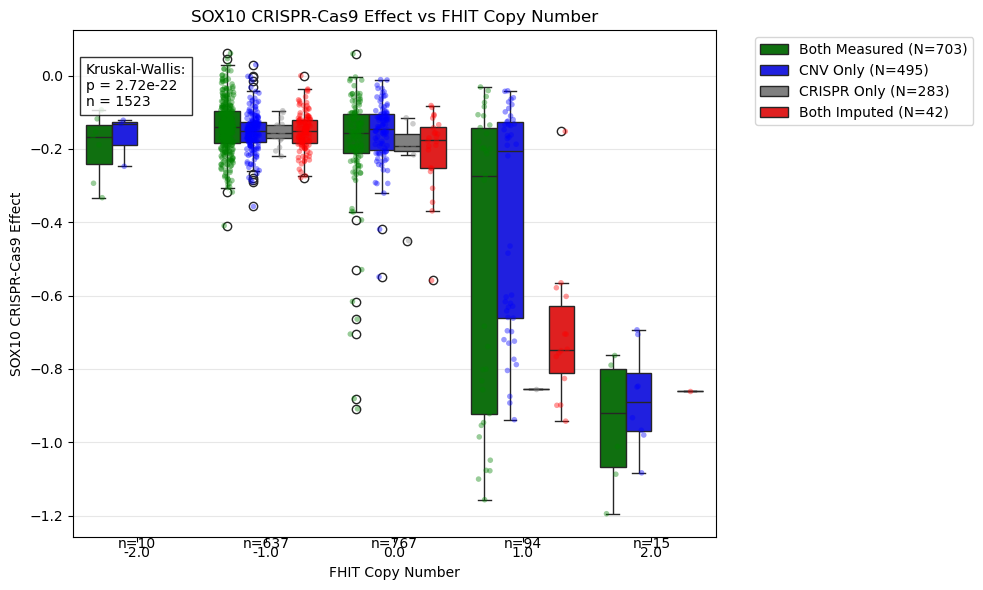

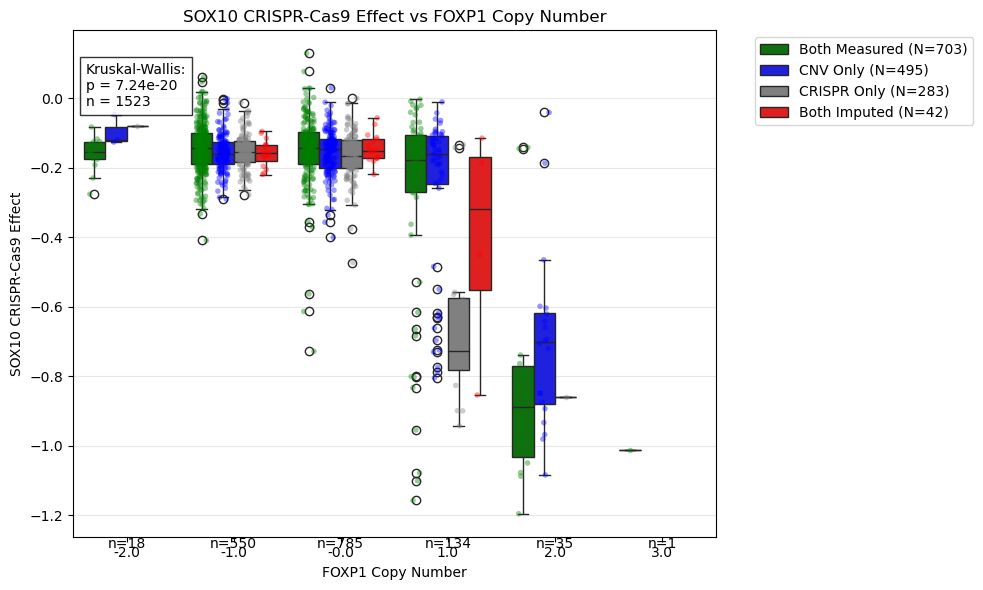

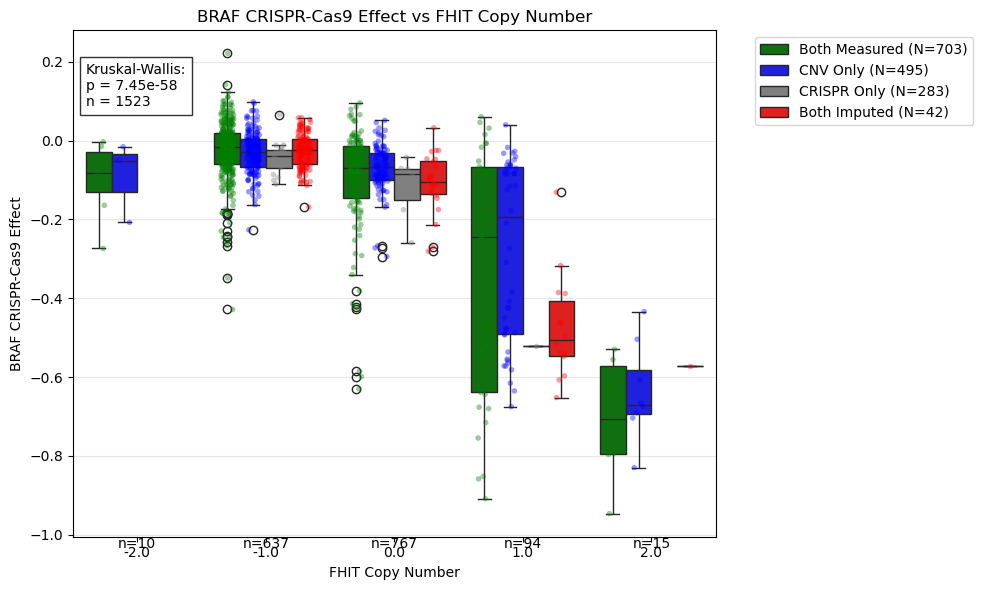

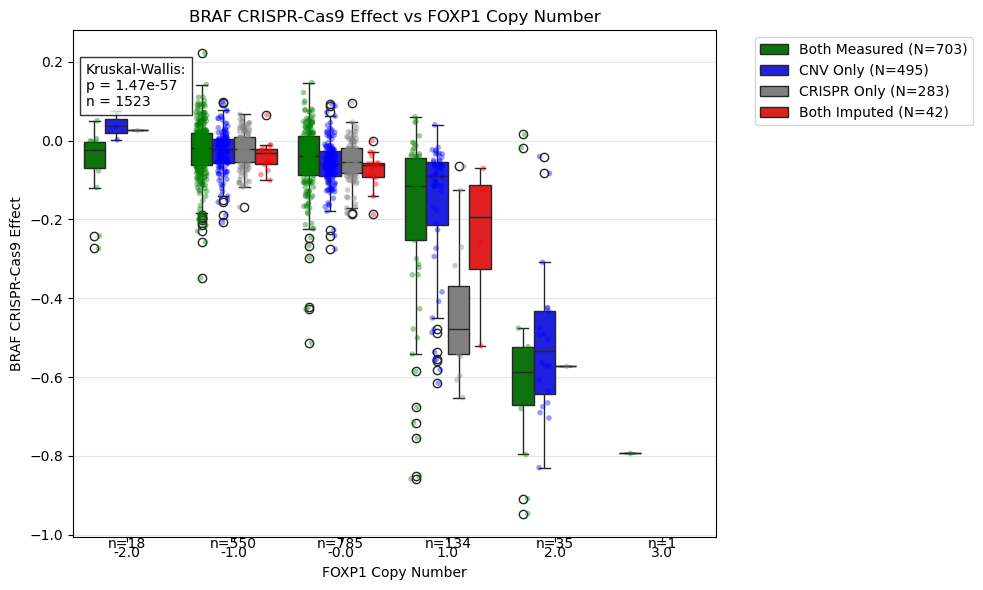

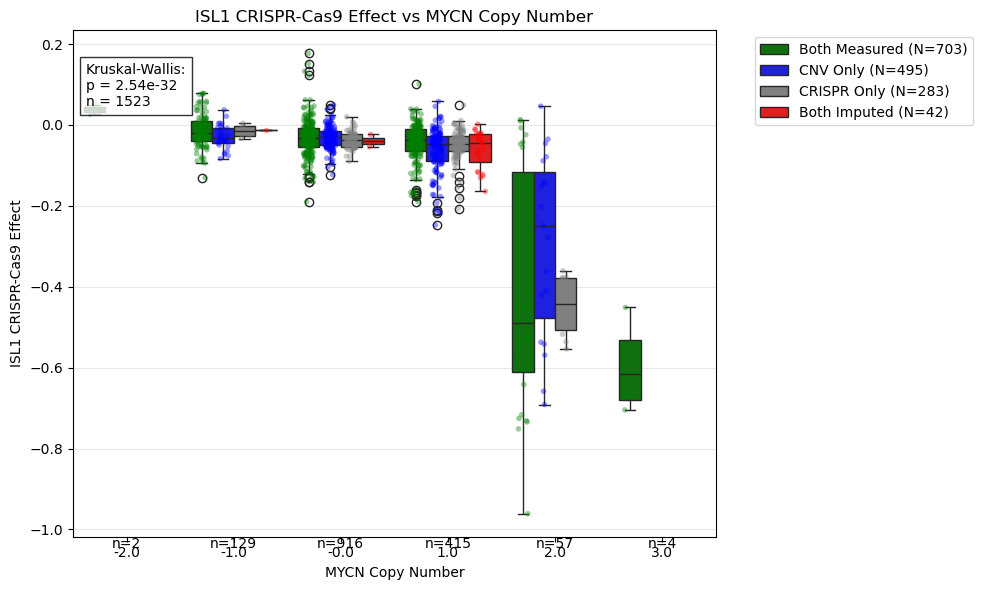

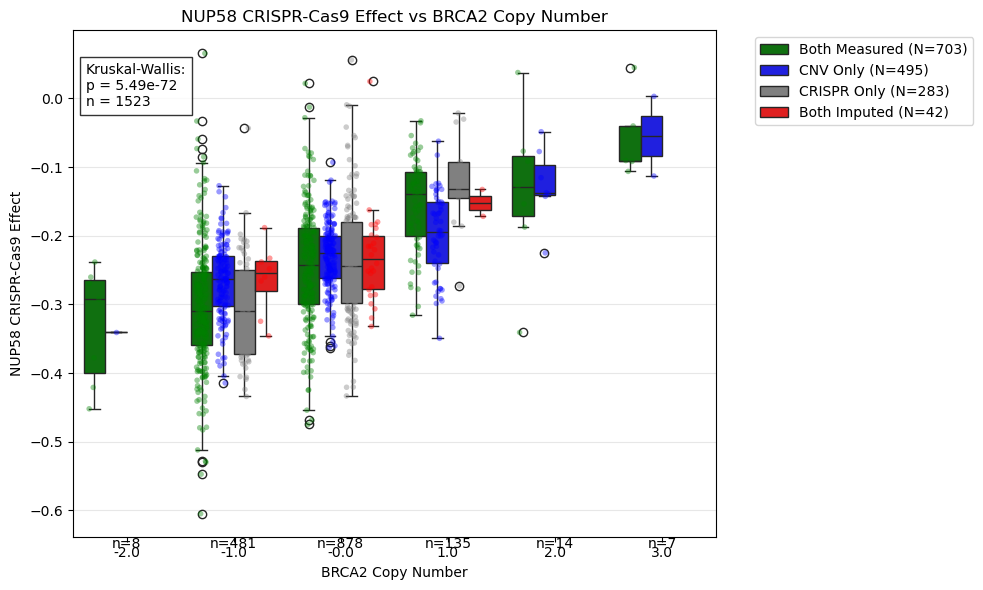

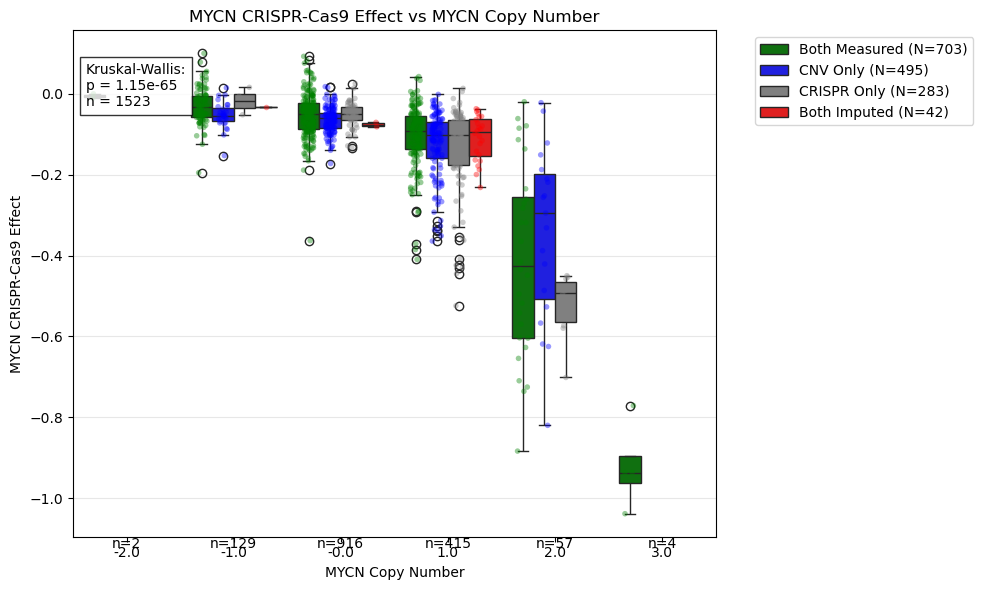

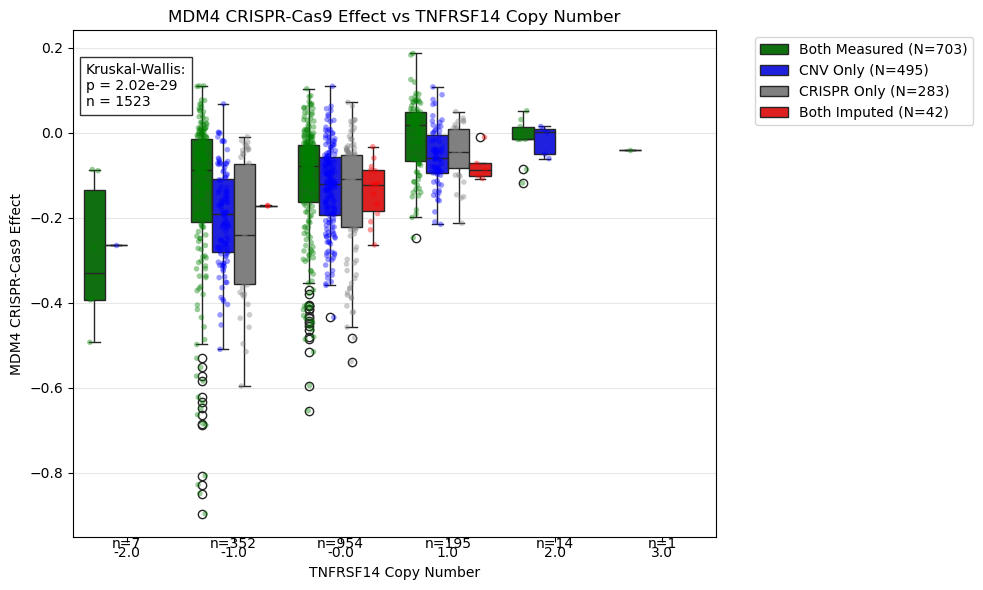

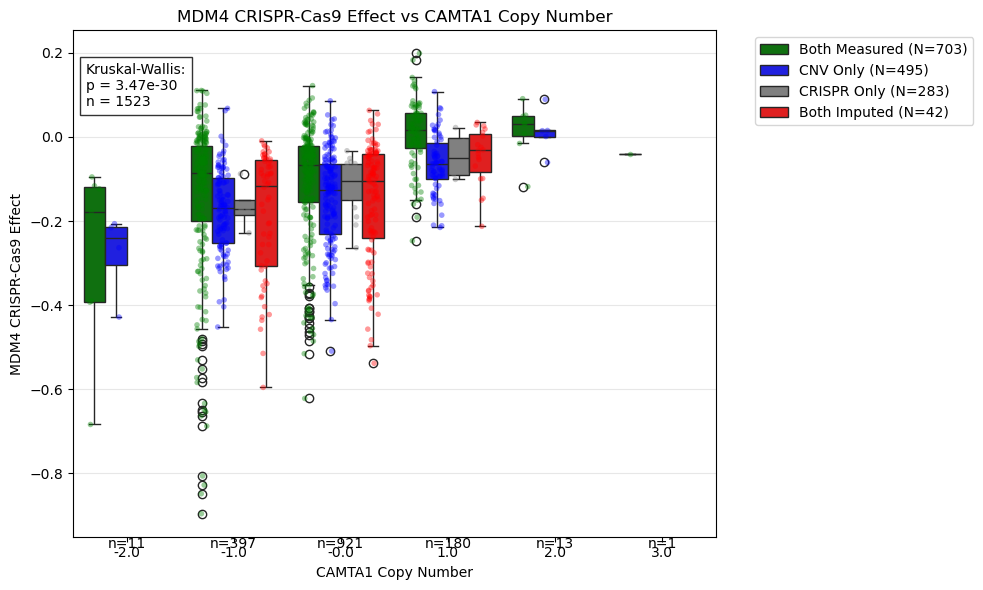

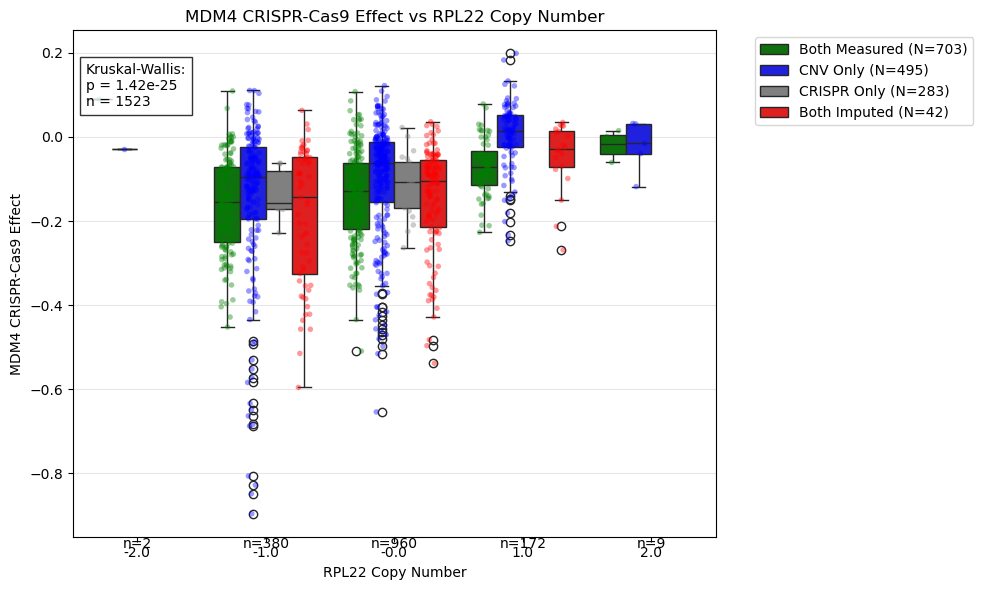

In [21]:
for row in df_res_vae_annot[COLS].head(10).itertuples():
    plot_cnv_boxplot(
        row.y_id,
        row.x_id,
        measured_groups=measured_groups,
        model_list_df=ss_cmp,
    )

# tissue level

In [11]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue.csv.gz"
)
df_res_vae["log10p_orig"] = -np.log10(df_res_vae["pval_orig"])
df_res_vae["log10p_vae"] = -np.log10(df_res_vae["pval_vae"])
df_res_vae["diff_log10p"] = df_res_vae["log10p_vae"] - df_res_vae["log10p_orig"]
df_res_vae = df_res_vae.sort_values("diff_log10p", ascending=False)

In [25]:
df_res_vae.loc[:,"n_samples_diff"] = (
    df_res_vae["n_samples_vae"] - df_res_vae["n_samples_orig"]
)
df_res_vae.loc[:,"n_samples_diff_pct"] = (
    df_res_vae["n_samples_diff"] / df_res_vae["n_samples_orig"]
)

In [46]:
df_res_vae = df_res_vae.query("log10p_vae > 5")
df_res_vae = df_res_vae.query("log10p_orig < 3")
df_res_vae = df_res_vae[df_res_vae["beta_vae"].abs() > 0.03]

In [54]:
df_res_vae.shape

,y_id,x_id,n_orig,beta_orig,lr_orig,covs_orig,pval_orig,fdr_orig,n_vae,beta_vae,...,pval_vae,fdr_vae,tissue,n_samples_orig,n_samples_vae,log10p_orig,log10p_vae,diff_log10p,n_samples_diff,n_samples_diff_pct
17194897,SOX10,CALHM5,24.0,-0.015892,3.103970,12.0,0.078102,0.306459,60.0,-0.033827,...,3.876463e-10,0.000002,Bone,24,60,1.107340,9.411564,8.304224,36,1.500000
17396226,TMEM119,RNF165,24.0,-0.019991,2.405121,12.0,0.120939,0.399384,60.0,-0.045552,...,6.044376e-10,0.000003,Bone,24,60,0.917434,9.218649,8.301214,36,1.500000
41297969,ZW10,AP3B2,29.0,0.032839,7.105213,12.0,0.007686,0.099559,38.0,0.046650,...,2.795408e-10,0.000002,Esophagus,29,38,2.114299,9.553555,7.439256,9,0.310345
17746881,UBE3B,RNF165,24.0,-0.012275,1.402067,12.0,0.236378,0.550942,60.0,-0.036987,...,9.054127e-09,0.000013,Bone,24,60,0.626393,8.043153,7.416760,36,1.500000
18211646,NRDE2,PCDH17,24.0,-0.017566,0.653222,12.0,0.418963,0.728114,60.0,-0.080033,...,3.132791e-08,0.000176,Bone,24,60,0.377824,7.504069,7.126244,36,1.500000


In [55]:
df_res_vae.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered.csv",
    index=False,
)

In [49]:
df_res_vae[
    ["tissue", "n_samples_diff", "n_samples_diff_pct"]
].drop_duplicates().sort_values("n_samples_diff_pct")

,tissue,n_samples_diff,n_samples_diff_pct
44175677,Biliary Tract,4,0.129032
38771445,Bladder,6,0.187500
32399673,Pancreas,10,0.232558
24876243,Soft Tissue,12,0.285714
41297969,Esophagus,9,0.310345
19226236,Ovary,16,0.320000
11001992,Large Intestine,24,0.480000
22193600,Head and Neck,23,0.511111
15869008,Breast,25,0.568182
36075809,Stomach,16,0.571429


In [50]:
df_res_vae.query("tissue == 'Bone'").head()

,y_id,x_id,n_orig,beta_orig,lr_orig,covs_orig,pval_orig,fdr_orig,n_vae,beta_vae,...,pval_vae,fdr_vae,tissue,n_samples_orig,n_samples_vae,log10p_orig,log10p_vae,diff_log10p,n_samples_diff,n_samples_diff_pct
17194897,SOX10,CALHM5,24.0,-0.015892,3.103970,12.0,0.078102,0.306459,60.0,-0.033827,...,3.876463e-10,0.000002,Bone,24,60,1.107340,9.411564,8.304224,36,1.5
17396226,TMEM119,RNF165,24.0,-0.019991,2.405121,12.0,0.120939,0.399384,60.0,-0.045552,...,6.044376e-10,0.000003,Bone,24,60,0.917434,9.218649,8.301214,36,1.5
17746881,UBE3B,RNF165,24.0,-0.012275,1.402067,12.0,0.236378,0.550942,60.0,-0.036987,...,9.054127e-09,0.000013,Bone,24,60,0.626393,8.043153,7.416760,36,1.5
18211646,NRDE2,PCDH17,24.0,-0.017566,0.653222,12.0,0.418963,0.728114,60.0,-0.080033,...,3.132791e-08,0.000176,Bone,24,60,0.377824,7.504069,7.126244,36,1.5
17131313,RBM19,RNF165,24.0,-0.049625,3.608262,12.0,0.057493,0.276705,60.0,-0.071953,...,6.914513e-09,0.000013,Bone,24,60,1.240384,8.160238,6.919855,36,1.5


In [51]:
df_res_vae.query("tissue == 'Lung'").head()

,y_id,x_id,n_orig,beta_orig,lr_orig,covs_orig,pval_orig,fdr_orig,n_vae,beta_vae,...,pval_vae,fdr_vae,tissue,n_samples_orig,n_samples_vae,log10p_orig,log10p_vae,diff_log10p,n_samples_diff,n_samples_diff_pct
2756661,KRAS,AREG,130.0,-0.034328,10.448756,12.0,0.001227,0.340522,257.0,-0.032931,...,0.000002,0.002127,Lung,130,257,2.911042,5.820702,2.909660,127,0.976923
2848433,SNAP23,SNAP25,130.0,0.031893,9.969746,12.0,0.001591,0.603426,257.0,0.030857,...,0.000005,0.028578,Lung,130,257,2.798239,5.294392,2.496153,127,0.976923
3016456,INTS6,LGALS1,130.0,0.054868,9.141567,12.0,0.002499,0.740181,257.0,0.045574,...,0.000010,0.026769,Lung,130,257,2.602291,5.021762,2.419471,127,0.976923


<Axes: title={'center': 'SOX10 (Cas9) vs CALHM5 (GEXP) (Bone)'}, xlabel='SOX10 (Cas9)', ylabel='CALHM5 (GEXP)'>

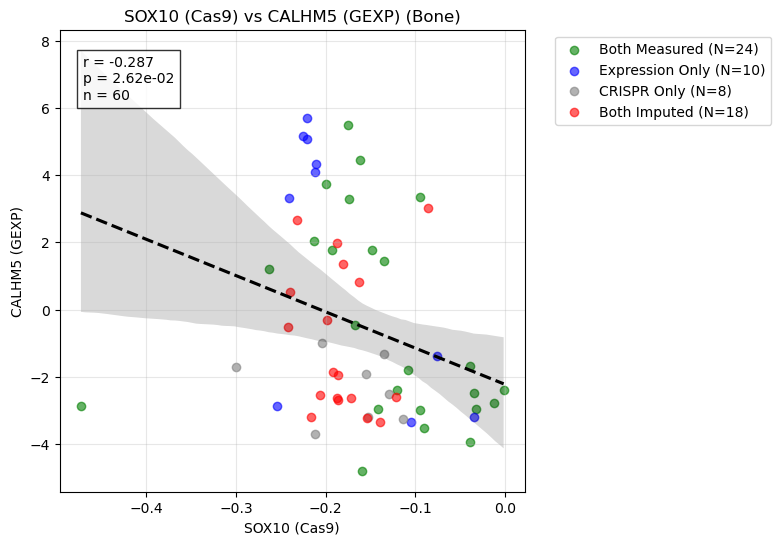

In [43]:
plot_scatter("SOX10", "CALHM5", measured_groups, "Bone", ss_cmp)

<Axes: title={'center': 'ZW10 (Cas9) vs AP3B2 (GEXP) (Esophagus)'}, xlabel='ZW10 (Cas9)', ylabel='AP3B2 (GEXP)'>

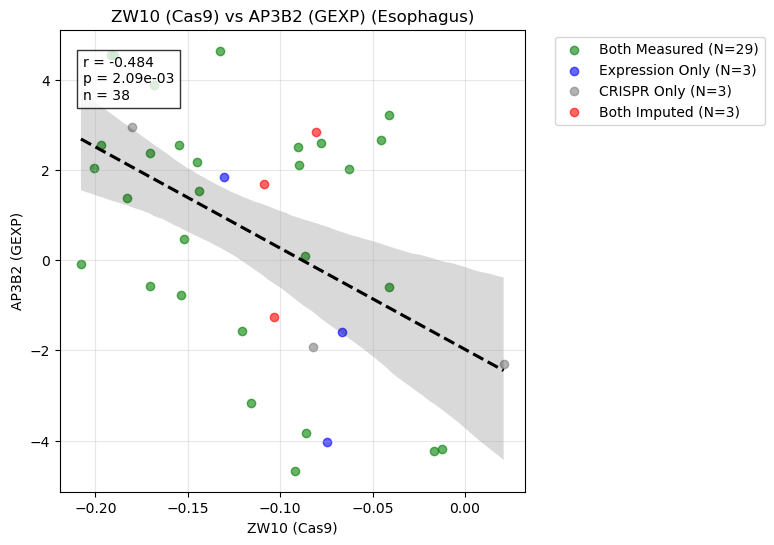

In [57]:
plot_scatter("ZW10", "AP3B2", measured_groups, tissue="Esophagus", model_list_df=ss_cmp)

<Axes: title={'center': 'KRAS (Cas9) vs AREG (GEXP) (Lung)'}, xlabel='KRAS (Cas9)', ylabel='AREG (GEXP)'>

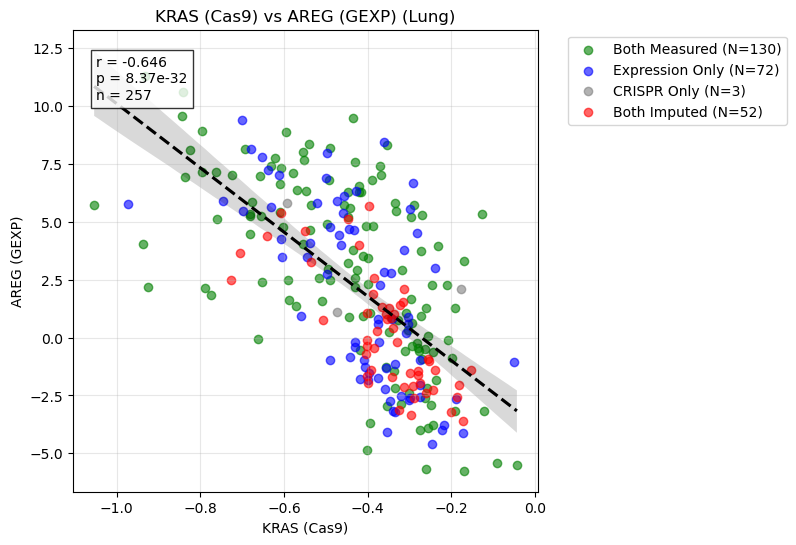

In [52]:
plot_scatter("KRAS", "AREG", measured_groups, "Lung", ss_cmp)